In [46]:
# 키워드 분석 클래스 시작
class KeywordAnalysis() :

    def __init__(self) :
        return None
    ### 전처리 모듈
    def preproc(self, reviews, custom_stopwords, custom_noun, spellcheck=False, stemming=False) :

        print("전처리 시작")

        import pandas as pd
        import numpy as np
        import re
        from ckonlpy.tag import Twitter
        from tqdm import tqdm

        #  문서군 변수 생성
        documents = []

        #  기존 불용어 위에 사용자 지정 불용어 적용
        with open("./한국어불용어_new.txt", "r", encoding="utf-8") as f :
            stop_words = f.read()
        f.close()
        stop_words = stop_words.split(",")
        stop_words.extend(custom_stopwords)

        #  사용자 지정 단어 사전 추가
        from ckonlpy.tag import Twitter
        custom_okt = Twitter()
        for n in custom_noun:
            custom_okt.add_dictionary(n, "Noun")

        #  결측치가 존재하는 record 제거
        reviews.dropna(inplace=True)

        #  의미있는한글(ㅋㅋ, ㅎㅎ이런거 말고), 알파벳, 숫자, 띄어쓰기 제외한 글자 삭제
        for idx, comment in enumerate(reviews["comment"]) :
            comment = re.sub(r"[^가-힣a-zA-Z0-9 ]", "", comment)
            reviews.iloc[idx,2] = comment

        #  띄어쓰기, 맞춤법 자동 교정 (갑자기 에러나서 일단 주석처리함)
        # if spellcheck :
        #     from hanspell import spell_checker
        #     for comment in tqdm(reviews["comment"]) :
        #         comment = spell_checker.check(comment).checked
        #         reviews.iloc[idx,2] = comment

        #  토큰화 
        
        #  (with 불용어 제거, 한글자 단어 제거)
        #  어간 추출하기
        if stemming :
            for comment in reviews["comment"] :
                document = []
                words = custom_okt.morphs(comment, stem=True)
                for word in words :
                    if (len(word) >= 2) or (word in custom_noun) :
                        if word not in stop_words :
                            document.append(word)
                documents.append(document)

        #  명사 키워드만 추출하기 (디폴트)
        else :  
            for comment in reviews["comment"] :
                document = []
                words = custom_okt.nouns(comment)
                for word in words :
                    if (len(word) >= 2) or (word in custom_noun) :
                        if word not in stop_words :
                            document.append(word)
                documents.append(document)

        #  문서군 변수 리턴
        #  데이터 타입 : 1차원 리스트
        #  데이터 구조 :
        #  documents = [[토큰1, 토큰2, 토큰3, ...], [토큰1, 토큰2, 토큰3, ...], ...]
        print("전처리 완료, 문서군 생성\n")
        return documents
    
    ### 카테고리별 단어등장한 문서개수 계산하는 모듈
    def category_count(self, documents) :

        print("category_count 실행\n")
        import pandas as pd
        import numpy as np

        #  리턴할 변수 생성
        result = None

        #  우리모두 엑셀로 만들었던 카테고리 데이터프레임 불러오기
        category = pd.read_csv("./카테고리 별 해당 키워드.csv")

        #  카운트한 값이 들어있는 데이터프레임 생성
        record_num = len(documents)
        column_num = len(category.columns)
        data = np.full((record_num, column_num), False)
        cat_cnt = pd.DataFrame(data, columns = category.columns)

        #  한 문서 안에 해당 카테고리의 단어가 존재하는지 체크
        #  (각 문서(record)별로, 해당 카테고리의 단어가 존재하면 True, False)
        idx = 0
        for document in documents :
            for word in document :
                if word in category["장르"].to_list() :
                    cat_cnt.iloc[idx, 0] = True

                elif word in category["스토리/캐릭터명"].to_list() :
                    cat_cnt.iloc[idx, 1] = True

                elif word in category["배우/연기"].to_list() :
                    cat_cnt.iloc[idx, 2] = True

                elif word in category["감독"].to_list() :
                    cat_cnt.iloc[idx, 3] = True

                elif word in category["영상미/연출"].to_list() :
                    cat_cnt.iloc[idx, 4] = True

                elif word in category["OST/사운드"].to_list() :
                    cat_cnt.iloc[idx, 5] = True

                elif word in category["감상"].to_list() :
                    cat_cnt.iloc[idx, 6] = True
                    
                elif word in category["기타"].to_list() :
                    cat_cnt.iloc[idx, 7] = True
            idx += 1

        # 각 카테고리의 단어가 언급된 문서들 개수를 계산
        result = cat_cnt.sum()

        # 최종 결과 리턴
        print("category_count 종료\n")
        return result
    

In [47]:
# 키워드 분석 모듈 끝
# ---------------------------------------------------------------------------- #


In [48]:
### 시각화 모듈 시작
class Visualization() :
    def __init__(self):
        return None

    # 파이차트랑 막대그래프 동시에 그려주는 모듈
    # (시각화 퀄리티가 구린건 나중에 손 볼 예정...)
    def pie_n_bar(self, result, title) :

        import pandas as pd
        import numpy as np
        import matplotlib
        import matplotlib.pyplot as plt
        #폰트 설정 한글 깨짐 오류 해결 코드 
        from matplotlib import font_manager, rc
        font_path = "C:/Windows/Fonts/NGULIM.TTF"
        font = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font)

        #  * 주의 : 이곳의 크기조절, 한글 글꼴설정은 VSCode용으로 제작된것.
        #  colab이나 주피터노트북에서는 다른 설정을 적용해야함.
        matplotlib.rcParams['figure.figsize'] = (12,7)
#         matplotlib.rcParams['font.family'] = "batang"
        matplotlib.rcParams['font.size'] = 10   
        matplotlib.rcParams["figure.facecolor"] = 'white'

        #  제목
        plt.suptitle(f"해당 카테고리의 키워드가 나온 문서 비율 & 개수 : {title}",fontsize=20)

        #  파이차트 생성
        #  (1행 2열 공간을 배정한 뒤, 첫번째 부분에 들어갈 그래프 생성)
        plt.subplot(1, 2, 1)
        
        values = []
        labels = []

        values.extend(result.values.tolist())
        labels.extend(result.index.to_list())
        
        wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 10}
        plt.pie(
            values, labels=labels,
            startangle=90, autopct='%.1f%%', counterclock=False, wedgeprops=wedgeprops)
        
        #  막대그래프 생성
        #  (1행 2열 공간을 배정한 뒤, 두번째 부분에 들어갈 그래프 생성)
        plt.subplot(1, 2, 2) 

        values = []
        labels = []

        values.extend(result.values.tolist())
        labels.extend(result.index.to_list())

        plt.bar(
            labels, values,
            width=0.7)
        plt.xticks(rotation=45)

        plt.xlabel("키워드", labelpad=11)
        plt.ylabel("문서 개수", labelpad=11)

        plt.savefig(f"시각화_{title}.png")
        plt.show()
        

In [49]:
# import matplotlib as mpl

# print(mpl.matplotlib_fname())

In [50]:
# 시각화 클래스 끝 
# ============================================================================ #


In [51]:
### 전역변수부

#  내가 직접 지정한 불용어 리스트 작성
custom_stopwords = [
    "범죄도시", "범죄 도시", "범죄", "도시", "죽지",
    "늑대사냥", "늑대", "사냥",
    "공조", "인터네셔날","인터내셔날",
    "한산", "용", "용의", "출현", "용의출현", "장군님", "장군",
    "뜨거운피", "피", "뜨거운",
    "외계인", "외계", "인",
    "영화", "무비", "영화관", "한국영화",
    "진짜", "진자", "완전", "존나", "졸라", "느낌", "뭔가", "제일", "개", "보고", "사람", "보지",
    "어요", "오늘", "그냥", "생각", "면서", "더니", "인적", "거지", "보기", "나름", "살짝",
    "정말", "대박", "역대", "최고", "어제", "편이", "계속", "요소", "처럼", "이나", "역시", "부분", "던데",
    "스포", "개봉", "한번", "내내", "구나", "때문", "어서", "정도", "다가", "다시", "누가", "덕분", "항상",
    "봤는데", "왔는데",
    "스포일러가 포함된 감상평입니다.",
    "하나님", "영적", "그리스도", "성경"
]

#  ckonlpy에 추가할 단어 지정
custom_noun = [

    #  [ 범죄도시 ]
    "장이수", "강해상", "손석구", "마석도", "마동석", "마블리", "박지환", "윤계상",
    "2부", "2탄", "2편", "1부", "1탄", "1편",
    #  * 같은 단어 : 장이수=이수, 마석도=마동석=마블리
    #  * 불용어 처리하면 안되는 단어 :
    #  - 구씨 : 배우 손석구가 다른 작품에서 맡았던 케릭터 이름

    #  [ 늑대사냥 ]
    "서인국", "장동윤", "박호산", "정소민", "고창석", "성동일",
    "콘에어", "콘 에어", "잔인",
    #  * 같은 단어 : 콘에어=콘 에어
    #  * 불용어 처리하면 안되는 단어 :
    #  - 콘에어 : 니콜라스 케이지 출연 1997년 영화. 늑대사냥과 비슷한 소재를 다루고있음.

    #  [ 공조2 ]
    "현빈", "유해진", "윤아", "다니엘 헤니", "다니엘헤니", "다니엘", "헤니", "진선규",
    "장영남", "박훈", "임성재", "림청렬", "청렬", "강진태", "진태", "장명준", "박소연",
    "박상위", "박민영",
    "불시착", "사랑의 불시착",
    # 같은 단어 : 다니엘헤니=다니엘=헤니, 불시착=사랑의 불시착

    #  [ 외계인1부 ]
    "류준열", "김우빈", "김태리", "소지섭", "염정아", "조우진", "이하늬",
    "무륵", "김현중", "이안", "문도석", "흑설", "청운",
    "2부", "2탄", "2편", "1부", "1탄", "1편", "돈", "SF", "sf", "SF물", "sf물",
    #  * 불용어 처리하면 안되는 단어 :
    #  - 돈 : 한 글자 '돈 아깝다'같은 말이 종종 보임.
    #  - SF, sf : 장르명. 한글이 아니라고해서 없애면 안됨.

    #  [ 한산 ]
    "박해일", "안성기", "변요한", "손현주", "김성규", "김성균", "김향기", "택연", "옥택연",
    "이순신", "장군님", "장군", "어영담", "원균", "준산", "히데요시", "도요토미", "도요토미 히데요시",
    "한산도", "대첩", "한산도 대첩", "임진왜란", "유키나가", "학익진",
    #  * 같은 단어 : 이순신=이순신장군
    #  * 불용어 처리하면 안되는 단어 :
    #  - 하라 : '전군 출정하라', '선회하라', '발포하라'가 이 영화의 명대사인가봄.

    # 뜨거운피 배우명/등장인물명
    "정우", "김갑수", "최무성", "지승현", "김해곤", "윤지혜", "이홍내", "정호빈"
    #  * 불용어 처리하면 안되는 단어 :
    #  - 짱구 : 배우 정우가 다른 작품에서 맡았던 케릭터 이름

    ]

#  클래스 생성자 만들기
keywordAnalysis = KeywordAnalysis()
visualization = Visualization()

In [52]:
# 전역변수부 끝
# ============================================================================ #

전처리 시작


C:\Users\hyha1\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


전처리 완료, 문서군 생성

category_count 실행

category_count 종료



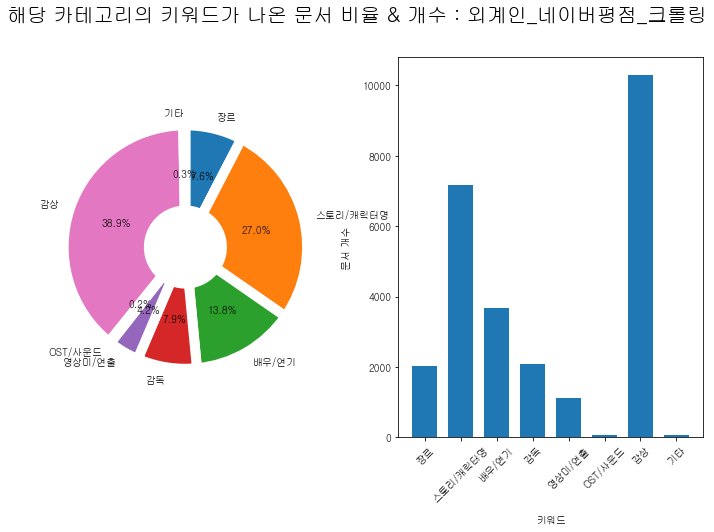

In [65]:
### 메인부

if __name__ == "__main__" :

    from glob import glob
    import re
    import pandas as pd
    import numpy as np

#     file_names = glob("youtube_외계인_예고편.csv")
    i = 0
#     for file_name in file_names :
#     if i == 1 : break
#     i += 1
    reviews = pd.read_csv('./외계인_네이버평점_크롤링.csv', encoding='utf-8', sep=",")
    documents = keywordAnalysis.preproc(reviews, custom_stopwords, custom_noun)

#     file_name = re.sub(r".*\\", "", file_name)  
#     file_name = re.sub(r"\.csv", "", file_name)  # 파일 저장하기 편하려고...

    cat_cnt_df = keywordAnalysis.category_count(documents)
    visualization.pie_n_bar(cat_cnt_df, '외계인_네이버평점_크롤링')

In [ ]:
# 메인부 끝
# ============================================================================ #